In [25]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = ".jenhantao@gmail.com"

### import Python packages ###
import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import sklearn
from sklearn import cross_validation
from sklearn import linear_model
from collections import Counter
import time
from scipy.stats import hypergeom

### jupyter notebook configuration ###
%matplotlib inline
%load_ext autoreload
%autoreload 2

### change figure resolution ###
matplotlib.pylab.rcParams['savefig.dpi'] = 200

# ##set working directory ###
os.chdir('/gpfs/data01/glasslab/home/jtao/for_fun/')




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in Data

In [284]:
# read in target and background population as data frames
target_pages_frame = pd.read_csv('boogiemadepages.csv', sep=',')

background_pages_frame = pd.read_csv('allCaliforniaUnder30pages.csv', sep=',')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Refactor Data Shape

In [ ]:
# get unique target users and pages
target_users = sorted(set(target_pages_frame['user_id'].values.astype(str)))
target_pages = sorted(set(target_pages_frame['page_title'].values.astype(str)))

# create empty data frame
target_user_page_frame = pd.DataFrame(np.zeros((len(target_users),
                                                len(target_pages))), 
                                      index = target_users, 
                                      columns= target_pages)

# loop through original data frame
counter = 0
for x in zip(target_pages_frame['user_id'].values,
             target_pages_frame['page_title'].values
            ):
    # update the count for each user like pair
    target_user_page_frame.ix[str(x[0]),str(x[1])] +=1
    counter+=1
    if counter %10000 ==0:
        print(counter)

# serialize refactored data object
target_user_page_frame.to_pickle('./target_user_page_frame.pickle')

In [ ]:
# get unique background users and pages
# use only 2000 background users for the sake of lower CPU time 
# watch out for class inbalance between target and background sets
background_users = sorted(set(background_pages_frame['user_id'].values.astype(str)))[:2000]
filtered_background_pages_frame = background_pages_frame[background_pages_frame['user_id'].isin(background_users)]
background_pages = sorted(set(filtered_background_pages_frame['page_title'].values.astype(str)))

# create empty data frame
background_user_page_frame = pd.DataFrame(np.zeros((len(background_users),
                                                    len(background_pages))), 
                                          index = background_users, 
                                          columns= background_pages)

counter = 0
for x in zip(filtered_background_pages_frame['user_id'].values,
             filtered_background_pages_frame['page_title'].values
            ):
    #update teh count for each use like pair
    background_user_page_frame.ix[str(x[0]),str(x[1])] +=1
    counter+=1
    if counter %10000 ==0:
        print(counter)
# serialize refactored data frame
background_user_page_frame.to_pickle('./background_user_page_frame.pickle')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [2]:
### read in serialized objects (if restarting notebook) ###
target_user_page_frame = pd.read_pickle('./target_user_page_frame.pickle')
background_user_page_frame = pd.read_pickle('./background_user_page_frame.pickle')

In [3]:
### convert user page like counts to boolean values ###
bool_target_user_page_frame = (target_user_page_frame > 0) +0
bool_background_user_page_frame = (background_user_page_frame > 0) +0

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


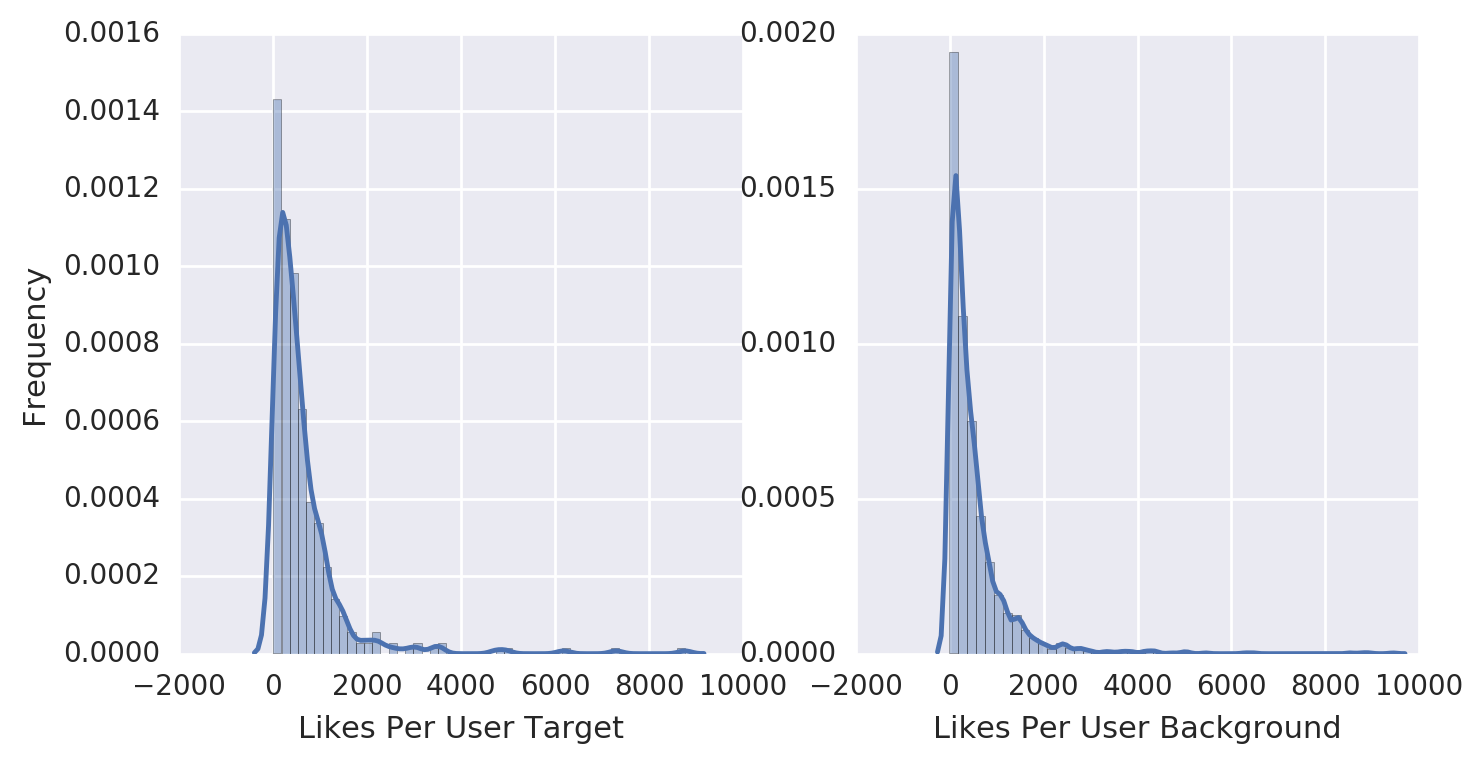

In [4]:

f, axs = plt.subplots(1,2, figsize=(8,4))

plt.subplot(1,2,1)  
sns.distplot(bool_target_user_page_frame.sum(axis=1))
plt.xlabel('Likes Per User Target')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.distplot(bool_background_user_page_frame.sum(axis=1))
plt.xlabel('Likes Per User Background')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 500)

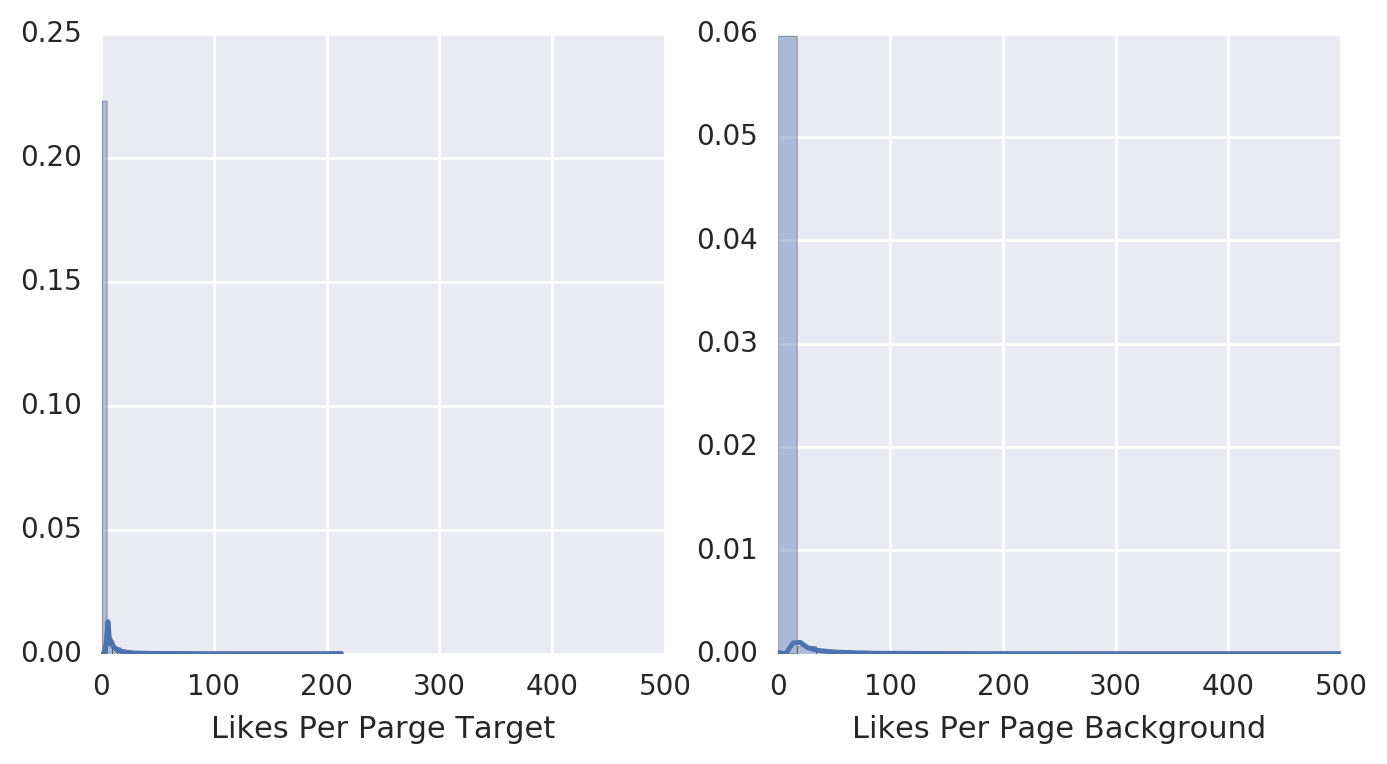

In [5]:
f, axs = plt.subplots(1,2, figsize=(8,4))

plt.subplot(1,2,1)  
sns.distplot(bool_target_user_page_frame.sum(axis=0))
plt.xlabel('Likes Per Parge Target')
plt.xlim(0,500)

plt.subplot(1,2,2)
sns.distplot(bool_background_user_page_frame.sum(axis=0))
plt.xlabel('Likes Per Page Background')
plt.xlim(0,500)

### Find Threshold for filtering pages

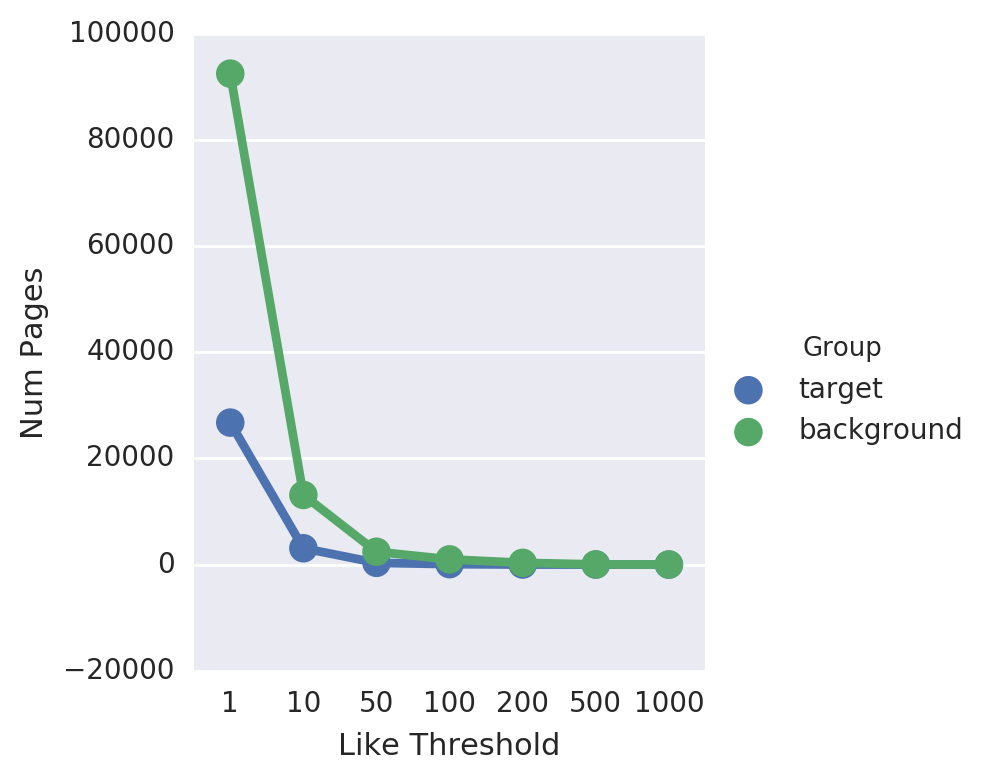

In [6]:
thresholds = []
numPages = []
groups = []

for ct in [1, 10, 50, 100, 200, 500, 1000]:
    sums = bool_target_user_page_frame.sum(axis=0)
    pagesOverThreshold = np.sum(sums>ct)
    thresholds.append(ct)
    numPages.append(pagesOverThreshold)
    groups.append('target')

    sums = bool_background_user_page_frame.sum(axis=0)
    pagesOverThreshold = np.sum(sums>ct)
    thresholds.append(ct)
    numPages.append(pagesOverThreshold)
    groups.append('background')

frame = pd.DataFrame({'Like Threshold': thresholds, 'Group':groups, 'Num Pages': numPages})
sns.factorplot(data = frame, x = 'Like Threshold', y='Num Pages', hue = 'Group')

### merge target and background data



In [17]:
threshold = 0.01
target_page_sums = bool_target_user_page_frame.sum(axis=0)
filtered_target_pages = target_page_sums[target_page_sums> threshold*bool_target_user_page_frame.shape[0]].index.values

background_page_sums = bool_background_user_page_frame.sum(axis=0)
filtered_background_pages = background_page_sums[background_page_sums> threshold*bool_background_user_page_frame.shape[0]].index.values

all_pages = set(filtered_target_pages).union(set(filtered_background_pages))

In [ ]:


# insert empty columns for pages that are not common to both groups of users
toMerge_target_frame = bool_target_user_page_frame[[]]
toMerge_background_frame = bool_background_user_page_frame[[]]

print(len(filtered_background_pages),len(filtered_target_pages),len(all_pages))
counter = 0
for p in sorted(all_pages):
    if not p in bool_target_user_page_frame.columns:
        toMerge_target_frame.ix[:,p] = 0
    else:
        toMerge_target_frame.ix[:,p] = bool_target_user_page_frame[p].values
    if not p in bool_background_user_page_frame.columns:
        toMerge_background_frame.ix[:,p] = 0
    else:
        toMerge_background_frame.ix[:,p] = bool_background_user_page_frame[p].values
    counter += 1
    if counter %100 ==0:
        print(counter)

### concatenate data frames ###
merged_user_page_frame = pd.concat([toMerge_target_frame, toMerge_background_frame])

### serialize data frame ###
merged_user_page_frame.to_pickle('./merged_user_page_frame.pickle')

### read data frame ###
merged_user_page_frame = pd.read_pickle('./merged_user_page_frame.pickle')

6680 8164 9630


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is try

100
200


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


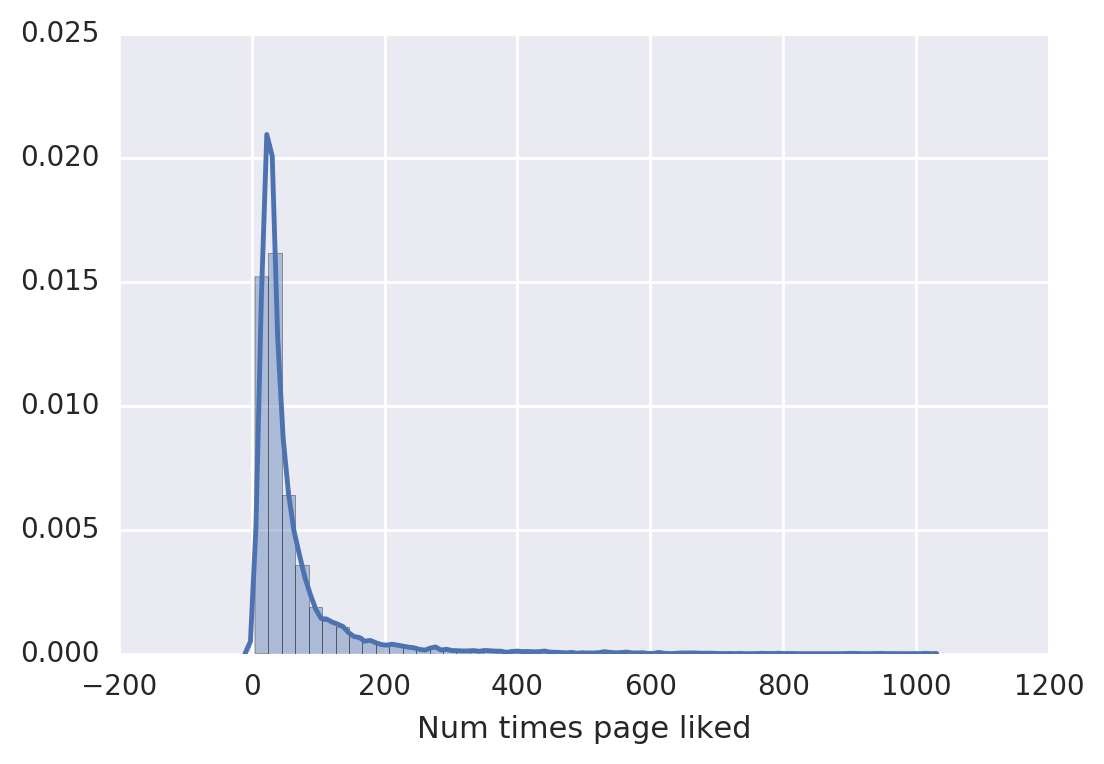

In [8]:
sns.distplot(merged_user_page_frame.sum(axis=0))
plt.xlabel('Num times page liked')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


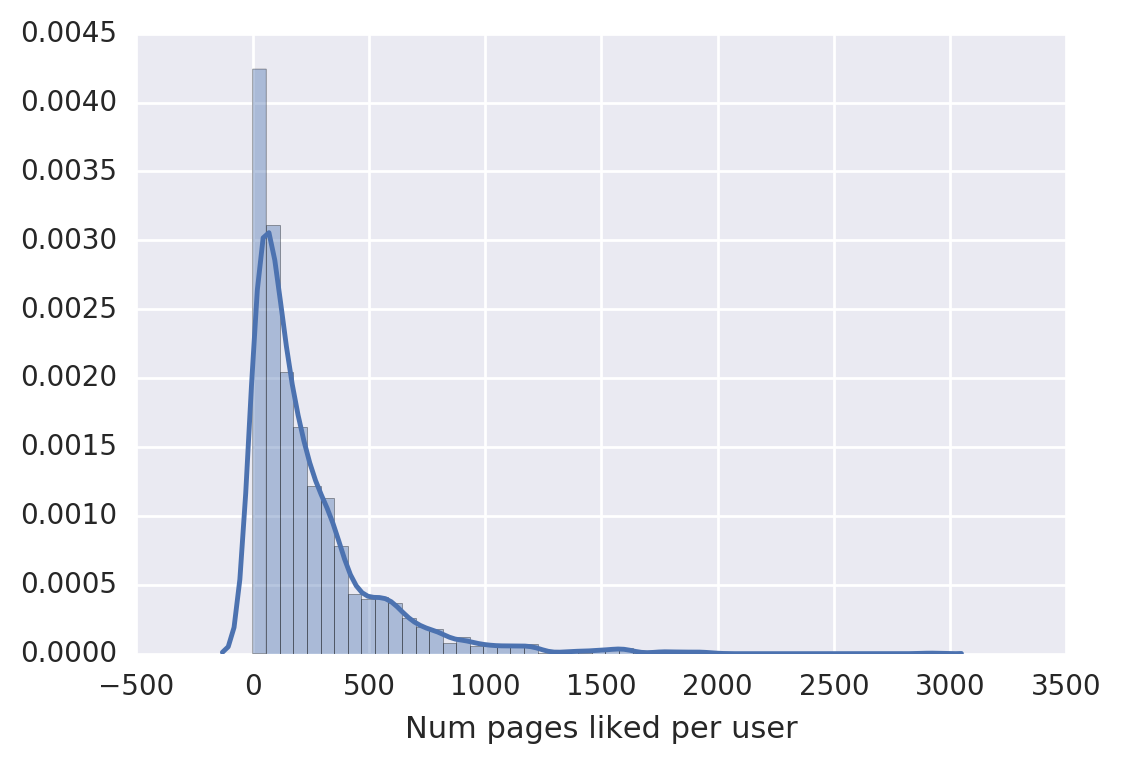

In [9]:
sns.distplot(merged_user_page_frame.sum(axis=1))
plt.xlabel('Num pages liked per user')

## Hypergeometric Test on each page

In [11]:
target_users = bool_target_user_page_frame.index.values
background_users = bool_background_user_page_frame.index.values

M = len(target_users) + len(background_users)# total number of objects; total number of people
N = len(target_users) # N drawn without replacement, number of target users that like a page

page_list = []
pval_list = []
ratio_list = []
# counter = 0
print('num pages', merged_user_page_frame.shape[1])
for p in merged_user_page_frame.columns.values:
    target_values = merged_user_page_frame.ix[target_users, p].values
    background_values = merged_user_page_frame.ix[background_users, p].values
    n = np.sum(target_values) + np.sum(background_values) # n is total number of Type I objects; number of people like a page
    distribution = hypergeom(M, n, N)
    pval = distribution.pmf(np.sum(target_values))
    
    ratio = (np.sum(target_values)/len(target_users)+1)/(np.sum(background_values)/len(background_users)+1)
    page_list.append(p)
    pval_list.append(pval)
    ratio_list.append(ratio)
#     counter +=1
#     if counter % 100 == 0:
#         print(counter)

num pages 9630


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


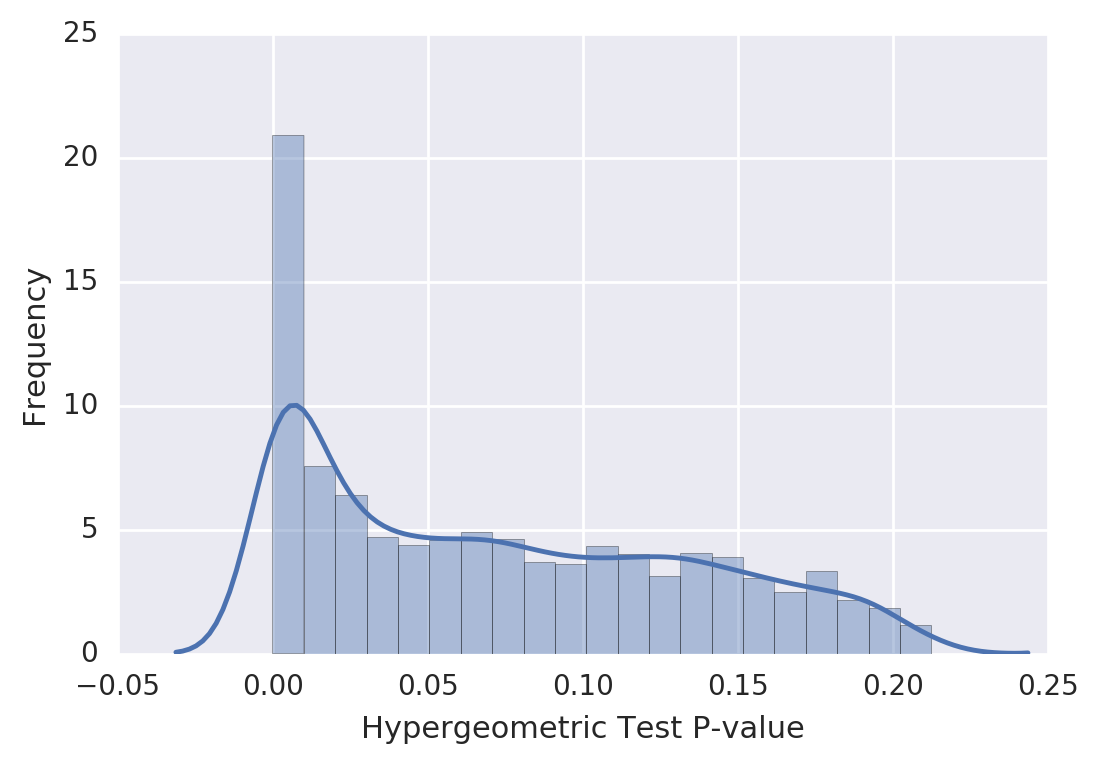

In [12]:
sns.distplot(pval_list)
plt.xlabel('Hypergeometric Test P-value')
plt.ylabel('Frequency')

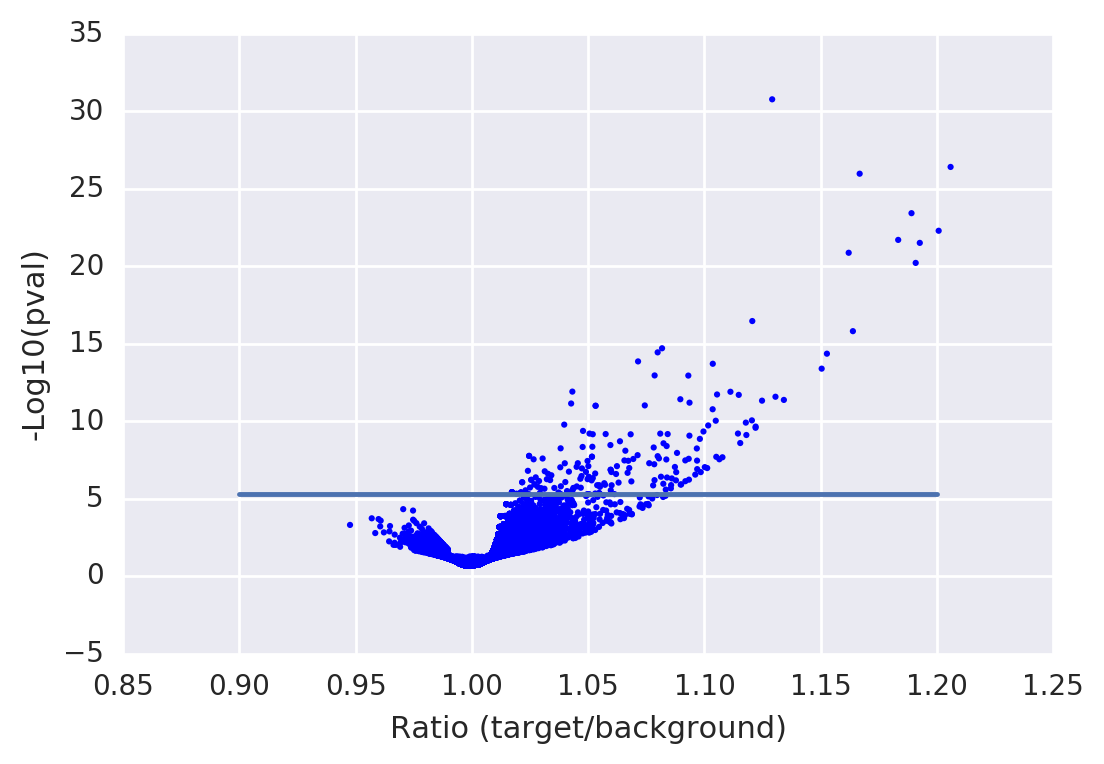

In [14]:
### plot enrichment in target vs. background vs p-value ###

plt.scatter(ratio_list,
            -1*np.log10(np.array(pval_list)), 
           edgecolor = 'None',
           s=5)
plt.xlabel('Ratio (target/background)')
plt.ylabel('-Log10(pval)')
significant_threshold = 0.05/len(pval_list) # bonferonni corrected p-value threshold
sig_yval = -1*np.log10(significant_threshold) # significant level cut off
plt.plot([0.9, 1.2], [sig_yval, sig_yval])

In [18]:
### sort and display signficant results according to enrichment ratio ###
hypergeo_frame = pd.DataFrame({'Page':list(all_pages), 'Ratio':ratio_list, 'pval':pval_list})

pval_threshold = 0.05/len(all_pages)
sig_frame = hypergeo_frame[(hypergeo_frame['pval'] < pval_threshold) & (hypergeo_frame['Ratio']>1)]


sig_frame.sort('Ratio', ascending=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Page,Ratio,pval
5407,inthemix,1.205864,3.965944e-27
4151,Heatbeat,1.200733,5.192623e-23
5686,GiveMeSport,1.192617,3.143377e-22
9516,Mac DeMarco,1.190854,6.158835e-21
3212,Mila Kunis,1.189051,3.813653e-24
418,The Woman in Black,1.183328,2.019440e-22
6540,Shaun of the Dead,1.166753,1.082760e-26
5970,Audrey Kawasaki's Art,1.163843,1.560165e-16
7305,Bedroom Producers Blog,1.162034,1.364942e-21
4183,The Dark Knight Rises,1.152668,4.430051e-15


In [24]:
# split data into matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [26]:
### run logistic regression classifier ###
numIterations = 5
test_size = 0.5

target_users = bool_target_user_page_frame.index.values
background_users = bool_background_user_page_frame.index.values

features = merged_user_page_frame
labels = pd.Series(data = [True if x in target_users else False for x in features.index.values],
                   index = features.index.values)

all_aucs = []
all_coefficients = []
all_precisions = []
for i in range(numIterations):

    # split data into training and test sets
    training_features, test_features, training_labels, test_labels = get_split(
        features, labels, test_size = test_size)
    #  Train affinity classifier
    classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
    classifier.fit(training_features, training_labels)

    probas = classifier.predict_proba(test_features)
    # score predictions
    current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
    current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

    all_aucs.append(current_roc_auc)
    all_precisions.append(current_precision)
    current_coefficients = classifier.coef_.flatten()
    all_coefficients.append(current_coefficients)

end = time.time()
mean_coefficients = np.mean(all_coefficients, axis=0)
print('roc:', np.mean(all_aucs), np.var(all_aucs),
      'precision:', np.mean(all_precisions), np.var(all_precisions),  
      'numTestPositives:', np.sum(test_labels),
     )


roc: 0.795055885268 0.000485929088134 precision: 0.55787620527 0.00293738152512 numTestPositives: 220


In [27]:

weight_frame = pd.DataFrame({'Page':features.columns.values,
                             'Importance':mean_coefficients})

In [28]:
### dump machine learning results as csv file ###
weight_frame.sort('Importance', ascending= False).to_csv('machine_learning_results.csv')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


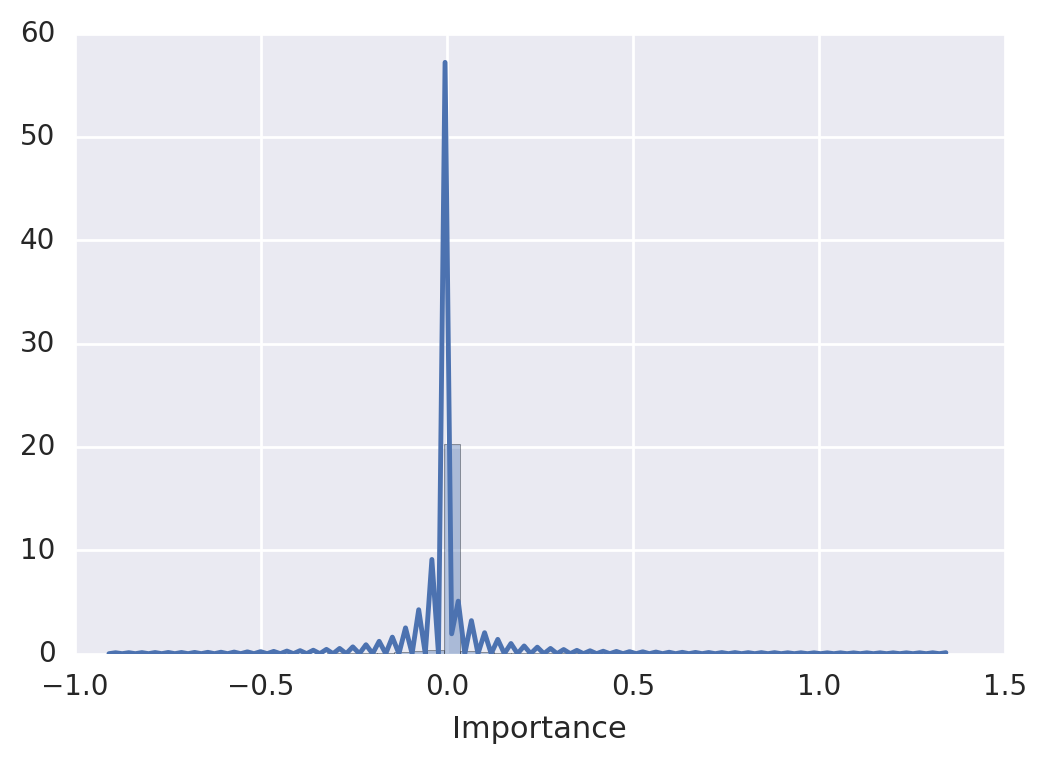

In [29]:
### plot distribution of machine learning weights ###
sns.distplot(weight_frame['Importance'])


In [31]:
### display sorted machine learning results ###
weight_frame.sort('Importance', ascending=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Importance,Page
1140,1.341902,Boogiemade
6540,1.121531,REZZ
553,1.113811,Anna Lunoe
5407,1.010771,Mija
2553,0.999954,Ekali
4090,0.892349,Insomniac.com
5109,0.885309,Mac Miller
8858,0.849195,Victoria's Secret
4520,0.768504,Kaskade
7272,0.663520,Slander
